# Run (with wandb)

In [1]:
from run.run import RunCoin
SRC_LEN, TGT_LEN = 200, 10
CHECKPOINT_PTH = '_checkpoints/coin_checkpoint.pth'

config = dict(
    run_quick=True,
    window_len=SRC_LEN+TGT_LEN,
    stride=20,
    src_len=SRC_LEN,
    tgt_len=TGT_LEN,
    embedding_dim=64,
    nhead=8,
    num_layers=(2, 2),
    ts_embed='wavenet',
    pos_embed='fixed',
    batch_size=64,
    lr=1e-3,
    betas=(0.9, 0.98),
    sch_stepsize=5,
    sch_gamma=0.5,
    es_patience=5,
    n_epoch=50,
)
synth = RunCoin('demo2', config, verbose=2, checkpoint_path=CHECKPOINT_PTH)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wittgensteinian (use `wandb login --relogin` to force relogin)


Start training


100%|██████████| 813/813 [00:52<00:00, 15.46it/s]


[Epoch 1] Train loss: -2.4931 Val loss: -2.9437
[Epoch 2] Train loss: -2.6709 Val loss: -2.9112
EarlyStopping counter: 1 out of 5
[Epoch 3] Train loss: -2.6846 Val loss: -2.7310
EarlyStopping counter: 2 out of 5
[Epoch 4] Train loss: -2.6937 Val loss: -2.8295
EarlyStopping counter: 3 out of 5
[Epoch 5] Train loss: -2.6899 Val loss: -2.8194
EarlyStopping counter: 4 out of 5
[Epoch 6] Train loss: -2.7302 Val loss: -2.9263
EarlyStopping counter: 5 out of 5
Finish training


epoch,5
train_loss,-2.73025
train_metric,0.02436
val_loss,-2.92635
val_metric,0.01965
_runtime,342
_timestamp,1627189759
_step,5


epoch,▁▂▄▅▇█
train_loss,█▃▂▂▂▁
train_metric,█▂▂▂▂▁
val_loss,▁▂█▅▅▂
val_metric,▁▃█▃▅▁
_runtime,▁▂▄▅▇█
_timestamp,▁▂▄▅▇█
_step,▁▂▄▅▇█


# Infer

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from tqdm import tqdm

from model.model import Transformer_fcst
from tools.infer import InferShortTerm, InferLongTerm
from tools.preprocess import make_input_target, make_src_tgt, cut_seq
from tools.train import make_loader

In [5]:
# device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# model
src_len, tgt_len = 200, 10
model = Transformer_fcst(fcst_mode='gauss',
                         seq_len=(src_len, tgt_len),
                         embedding_dim=64,
                         nhead=8,
                         num_layers=(2, 2),
                         device=device,
                         ts_embed='wavenet',
                         pos_embed='fixed').to(device)
model.load_state_dict(torch.load(CHECKPOINT_PTH))

# test data
test = np.load('./data_coin/test.npy')
test = test[:, :, 1:2]
test = cut_seq(test, window_len=src_len + tgt_len, stride=20)

input, target = make_input_target(test, src_len, tgt_len)
test_dloader = make_loader(input, target, batch_size=128)

# sample test dloader for quick execution
sample_idxs = np.random.choice(input.shape[0], 10000, replace=False)
input_sample, target_sample = input[sample_idxs], target[sample_idxs]
test_sample_dloader = make_loader(input_sample, target_sample, batch_size=128)

## Short-term forecasting (i.e. rolling-timestep forecast)

In [6]:
infershort = InferShortTerm(model)

### Eval

In [7]:
running_loss, running_metric = 0.0, 0.0
with torch.no_grad():
    for (input_batch, target_batch) in tqdm(test_dloader):
        input_batch, target_batch = input_batch.to(
            device), target_batch.to(device)
        src, tgt = make_src_tgt(input_batch, src_len, tgt_len)
        loss, metric = infershort.eval((src, tgt), target_batch)

        running_loss += loss.item()
        running_metric += metric.item()

print('Test loss:', running_loss / len(test_dloader))
print('Test metric:', running_metric / len(test_dloader))


100%|██████████| 806/806 [00:26<00:00, 29.85it/s]

Test loss: -2.793363675253267
Test metric: 0.021750393153743695


### Plot samples

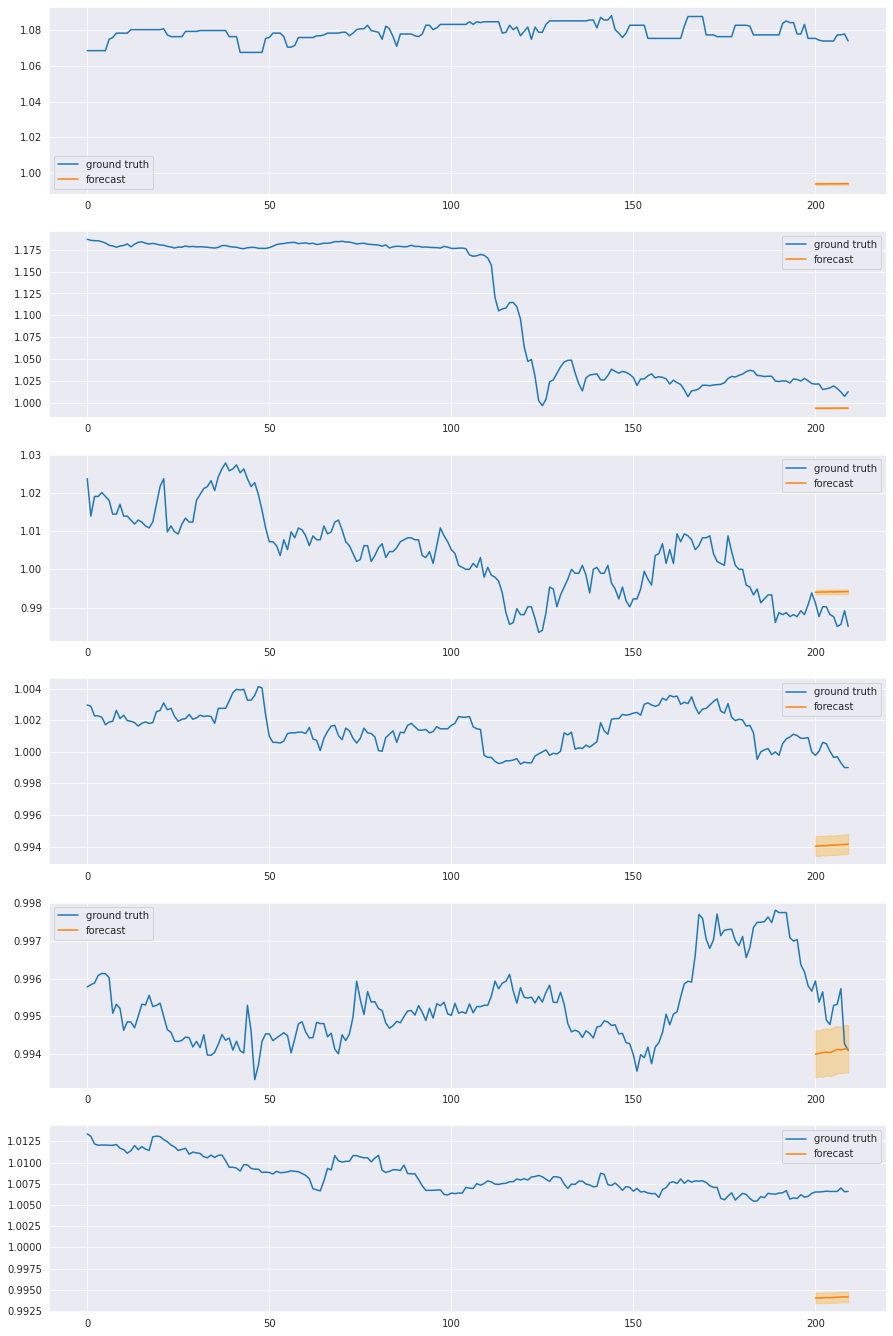

In [8]:
# canvas
fig, axes = plt.subplots(6,1, figsize=(15,24))

# sampling
sample_idxs = np.random.choice(input.shape[0], len(axes), replace=False)
input_sample, target_sample = input[sample_idxs], target[sample_idxs]

src, tgt = make_src_tgt(input_sample, src_len, tgt_len)

# plot
with torch.no_grad():
    src = torch.Tensor(src).to(device)
    tgt = torch.Tensor(tgt).to(device)
    target_sample = torch.Tensor(target_sample).to(device)
    infershort.plot((src,tgt), target_sample, axes)

## Long-term forecasting (i.e. with recurrence)
> The code is identical to short-term forecasting. Only difference is to use InferLongTerm instead of InferShortTerm.

In [9]:
inferlong = InferLongTerm(model)

### Eval

In [10]:
running_loss, running_metric = 0.0, 0.0
with torch.no_grad():
    for (input_batch, target_batch) in tqdm(test_sample_dloader):
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        src, tgt = make_src_tgt(input_batch, src_len, tgt_len)
        loss, metric = inferlong.eval((src, tgt), target_batch)
        
        running_loss += loss.item()
        running_metric += metric.item()

print('Test loss:', running_loss / len(test_dloader))
print('Test metric:', running_metric / len(test_dloader))

100%|██████████| 79/79 [04:19<00:00,  3.28s/it]

Test loss: -0.2748622116320778
Test metric: 0.0021472753166560795


### Plot samples

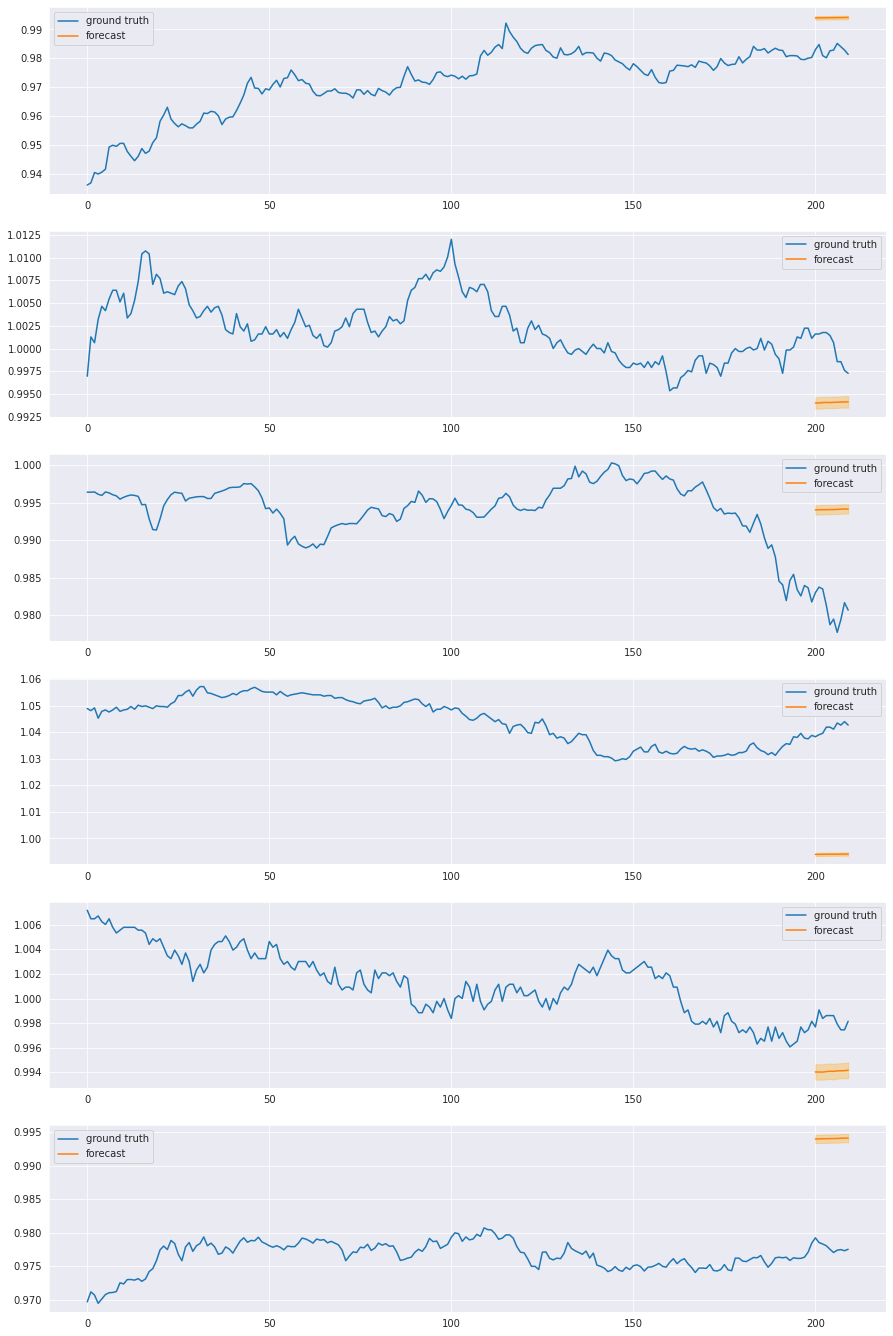

In [11]:
# canvas
fig, axes = plt.subplots(6, 1, figsize=(15, 24))

# sampling
sample_idxs = np.random.choice(input.shape[0], len(axes), replace=False)
input_sample, target_sample = input[sample_idxs], target[sample_idxs]

src, tgt = make_src_tgt(input_sample, src_len, tgt_len)

# plot
with torch.no_grad():
    src = torch.Tensor(src).to(device)
    tgt = torch.Tensor(tgt).to(device)
    target_sample = torch.Tensor(target_sample).to(device)
    inferlong.plot((src, tgt), target_sample, axes)